# Default CCT

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

class GPSABlock(layers.Layer):
    """
    Generalized Positional Self-Attention (GPSA) block.
    """
    def __init__(self, dim, num_heads=8, attn_drop=0., proj_drop=0., locality_strength=1.):
        super(GPSABlock, self).__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qk = layers.Dense(dim * 2)  # Query and Key
        self.v = layers.Dense(dim)       # Value
        self.attn_drop = layers.Dropout(attn_drop)
        self.proj = layers.Dense(dim)
        self.proj_drop = layers.Dropout(proj_drop)

        self.pos_proj = layers.Dense(num_heads)
        self.locality_strength = locality_strength
        self.gating_param = tf.Variable(tf.ones([num_heads]), trainable=True, name="gating_param")

        self.rel_indices = None  # Initialized during build

    def build(self, input_shape):
        num_patches = input_shape[1]  # Sequence length
        if self.rel_indices is None or self.rel_indices.shape[1] != num_patches:
            self.rel_indices = self._get_rel_indices(num_patches)

    def _get_rel_indices(self, num_patches):
        img_size = int(num_patches ** 0.5)  # Assumes square grid
        x_coords, y_coords = tf.range(img_size, dtype=tf.float32), tf.range(img_size, dtype=tf.float32)
        x_grid, y_grid = tf.meshgrid(x_coords, y_coords)
        x_grid_flat, y_grid_flat = tf.reshape(x_grid, [-1]), tf.reshape(y_grid, [-1])
        dx = tf.expand_dims(x_grid_flat, axis=1) - tf.expand_dims(x_grid_flat, axis=0)
        dy = tf.expand_dims(y_grid_flat, axis=1) - tf.expand_dims(y_grid_flat, axis=0)
        distances = tf.sqrt(tf.square(dx) + tf.square(dy))
        rel_indices = tf.stack([dx, dy, distances], axis=-1)
        rel_indices = tf.reshape(rel_indices, (1, num_patches, num_patches, 3))
        return rel_indices
        

def call(self, x):
    input_shape = tf.shape(x)
    batch_size = input_shape[0]  # Batch size
    num_patches = input_shape[1]  # Number of patches
    _ = input_shape[2]  # Feature dimension (not used directly)

    # Compute query, key, value
    qk = self.qk(x)
    qk = tf.reshape(qk, (batch_size, num_patches, 2, self.num_heads, self.head_dim))
    query, key = tf.transpose(qk[:, :, 0, :, :], [0, 2, 1, 3]), tf.transpose(qk[:, :, 1, :, :], [0, 2, 1, 3])
    value = tf.transpose(tf.reshape(self.v(x), (batch_size, num_patches, self.num_heads, self.head_dim)), [0, 2, 1, 3])

    # Positional and patch-based attention scores
    pos_score = tf.nn.softmax(self.pos_proj(self.rel_indices), axis=-1)
    patch_score = tf.nn.softmax(tf.matmul(query, key, transpose_b=True) * self.scale, axis=-1)

    # Gating mechanism
    gating = tf.nn.sigmoid(self.gating_param)[tf.newaxis, :, tf.newaxis, tf.newaxis]
    attn = (1. - gating) * patch_score + gating * pos_score
    attn = attn / tf.reduce_sum(attn, axis=-1, keepdims=True)
    attn = self.attn_drop(attn)

    # Apply attention to value
    x = tf.matmul(attn, value)
    x = tf.transpose(x, [0, 2, 1, 3])
    x = tf.reshape(x, (batch_size, num_patches, self.dim))

    # Projection and dropout
    x = self.proj(x)
    x = self.proj_drop(x)
    return x


class MHSA(layers.Layer):
    """
    Multi-Head Self-Attention (MHSA) Layer with consistent output dimensions.
    """
    def __init__(self, projection_dim, num_heads):
        super(MHSA, self).__init__()
        self.num_heads = num_heads
        self.projection_dim = projection_dim
        self.query_dense = layers.Dense(projection_dim)
        self.key_dense = layers.Dense(projection_dim)
        self.value_dense = layers.Dense(projection_dim)
        self.combine_heads = layers.Dense(projection_dim)  # Ensure output matches projection_dim

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        score = score / tf.sqrt(tf.cast(self.projection_dim // self.num_heads, tf.float32))
        weights = tf.nn.softmax(score, axis=-1)
        output = tf.matmul(weights, value)
        return output

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim // self.num_heads))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_length = tf.shape(inputs)[1]  # Preserve sequence length

        query = self.split_heads(self.query_dense(inputs), batch_size)
        key = self.split_heads(self.key_dense(inputs), batch_size)
        value = self.split_heads(self.value_dense(inputs), batch_size)
        attention = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, seq_length, self.projection_dim))
        output = self.combine_heads(concat_attention)
        return output


def mlp(inputs, hidden_units, dropout, projection_dim):
    """
    MLP block with consistent output dimension.
    """
    x = layers.Dense(hidden_units[0], activation=tf.nn.gelu)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(hidden_units[1], activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(projection_dim)(x)
    return x

def Transformer_Encoder_with_Attention(L, embedded_patches, num_heads, projection_dim, transformer_units):
    for i in range(L):
        print(f"Input shape at Layer {i}: {embedded_patches.shape}")

        # Normalize input
        norm = layers.LayerNormalization(epsilon=1e-5)(embedded_patches)

        # GPSA block
        gpsa_output = GPSABlock(dim=projection_dim, num_heads=num_heads)(norm)
        print(f"GPSA output shape at Layer {i}: {gpsa_output.shape}")

        # MHSA block
        mhsa_output = MHSA(projection_dim, num_heads)(gpsa_output)
        print(f"MHSA output shape at Layer {i}: {mhsa_output.shape}")

        # Align dimensions for residual connection
        if mhsa_output.shape[-1] != projection_dim:
            mhsa_output = layers.Dense(projection_dim)(mhsa_output)  # Align dimensions to match projection_dim
        print(f"Aligned MHSA output shape at Layer {i}: {mhsa_output.shape}")

        # Residual connection
        skip1 = layers.Add()([mhsa_output, embedded_patches])
        print(f"Skip1 shape at Layer {i}: {skip1.shape}")

        # Normalize again
        norm2 = layers.LayerNormalization(epsilon=1e-5)(skip1)

        # Feed-forward network
        ffn = mlp(norm2, hidden_units=transformer_units, dropout=0.1, projection_dim=projection_dim)
        print(f"MLP output shape at Layer {i}: {ffn.shape}")

        # Second residual connection
        embedded_patches = layers.Add()([ffn, skip1])
        print(f"Output shape at Layer {i}: {embedded_patches.shape}")

    return embedded_patches
    
    
def CompactConvolutionalTransformer_with_Attention(image_size=224, num_classes=2, input_shape=(224, 224, 3),
                                                    projection_dim=128, num_heads=2, L=2, transformer_units=[128, 128]):
    """
    Compact Convolutional Transformer (CCT) with integrated GPSA and MHSA blocks.
    """
    inputs = layers.Input(shape=input_shape)
    conv_tokenizer = ConvolutionalTokenizer()
    embedded_patches = conv_tokenizer(inputs)
    pos_embed, seq_length = conv_tokenizer.pos_embeddings(image_size)
    positions = tf.range(start=0, limit=seq_length, delta=1)
    position_embeddings = pos_embed(positions)
    embedded_patches += position_embeddings
    embedded_patches = Transformer_Encoder_with_Attention(L, embedded_patches, num_heads=num_heads,
                                                          projection_dim=projection_dim,
                                                          transformer_units=transformer_units)
    sequence_pooling = SeqPool(embedded_patches)
    output = layers.Dense(num_classes, activation='softmax')(sequence_pooling)
    model = keras.Model(inputs=inputs, outputs=output)
    return model
    
    
    
    
def SeqPool(trans_enco_out):
    """
    Sequence Pooling block.
    
    Args: 
        trans_enco_out: Takes in the Output of transformer encoder block 
    
    Returns:
        A 1xD output to be fed to final classifier
    """
    # Normalizing the output of transformer enocder layer
    normalized = layers.LayerNormalization(epsilon=1e-5)(trans_enco_out)
    # Adding a linear layer
    linear=layers.Dense(1)(normalized)
    # Applying Softmax to the linear layer
    soft = tf.nn.softmax(linear, axis=1)
    # Multiplying the softmax of linear layer with the normalized output of orignal output of the transformer encoder block
    mult = tf.matmul(soft, normalized, transpose_a=True)
    # Squeezing the dimensions
    seq_pool_output = tf.squeeze(mult, -2)

    return seq_pool_output
    
    
    
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

class ConvolutionalTokenizer(layers.Layer):
    """
    Creates Convolutional Tokens of images for feeding to Transformer Encoder.
    """
    def __init__(self, kernel_size=3, stride=1, padding=1, pooling_kernel_size=3, pooling_stride=2,
                 conv_layers=2, num_output_channels=[64, 128], **kwargs):
        super(ConvolutionalTokenizer, self).__init__(**kwargs)
        
        # Creating a Sequential Keras Model for Tokenizing images
        self.conv_model = keras.Sequential()
        # Creating the required number of convolutional layers
        for i in range(conv_layers):
            # Adding a Conv2D layer with ReLU activation as suggested by authors
            self.conv_model.add(layers.Conv2D(num_output_channels[i], kernel_size, stride,
                                              padding="valid", use_bias=False, activation="relu",
                                              kernel_initializer="he_normal"))
            # Zero Padding
            self.conv_model.add(layers.ZeroPadding2D(padding))
            # Pooling over the image with 3x3 kernel, padding='same' and stride=2   
            self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))

    def call(self, images):
        # Pass RGB images through the convolutional model
        outputs = self.conv_model(images)
        # Flatten the output
        flattened = tf.reshape(outputs,
                               (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[3]))
        return flattened

    def pos_embeddings(self, image_size):
        # Ensure the input has 3 channels for RGB
        inp = tf.ones((1, image_size, image_size, 3))  # RGB shape
        out = self.call(inp)
        seq_len = tf.shape(out)[1]
        projection_dim = tf.shape(out)[-1]

        # Define the positional embedding layer
        embed_layer = layers.Embedding(input_dim=seq_len, output_dim=projection_dim)
        return embed_layer, seq_len



In [3]:
# Define Model Parameters
image_size = 224
n_classes = 2
batch_size = 32
learning_rate = 0.001
num_epochs = 100
projection_dim = 128
num_heads = 2
transformer_units = [256, 128]  # MLP layers in the Transformer
transformer_layers = 2  # Number of Transformer Encoder layers

# Instantiate the Compact Transformer Model with GPSA
cct = CompactConvolutionalTransformer_with_Attention(
    image_size=image_size,
    num_classes=n_classes,
    input_shape=(image_size, image_size, 3),
    projection_dim=projection_dim,
    num_heads=num_heads,
    L=transformer_layers,
    transformer_units=transformer_units,
)



Input shape at Layer 0: (None, 3136, 128)
GPSA output shape at Layer 0: (None, 3136, 128)
MHSA output shape at Layer 0: (None, 3136, 128)
Aligned MHSA output shape at Layer 0: (None, 3136, 128)
Skip1 shape at Layer 0: (None, 3136, 128)
MLP output shape at Layer 0: (None, 3136, 128)
Output shape at Layer 0: (None, 3136, 128)
Input shape at Layer 1: (None, 3136, 128)
GPSA output shape at Layer 1: (None, 3136, 128)
MHSA output shape at Layer 1: (None, 3136, 128)
Aligned MHSA output shape at Layer 1: (None, 3136, 128)
Skip1 shape at Layer 1: (None, 3136, 128)
MLP output shape at Layer 1: (None, 3136, 128)
Output shape at Layer 1: (None, 3136, 128)


In [4]:
from tensorflow.keras.models import load_model
weights_path = r'E:\Projects\Content-moderation\weights\compact_transformer_gpsa (1).hdf5'
# cct = CompactConvolutionalTransformer_with_Attention()
cct.load_weights(weights_path)



print("HDF5 model weights loaded successfully!")

HDF5 model weights loaded successfully!


In [5]:
print(cct.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convolutional_tokenizer (Convo  (None, 3136, 128)   75456       ['input_1[0][0]']                
 lutionalTokenizer)                                                                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 3136, 128)   0           ['convolutional_tokenizer[0][0]']
 da)                                                                                          

# GradCAM

1/1 [==============================] - 0s 409ms/step
Predicted: [[0.4934506 0.5065494]]


C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_18700\1766087969.py:64: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mpl.cm.get_cmap("jet")


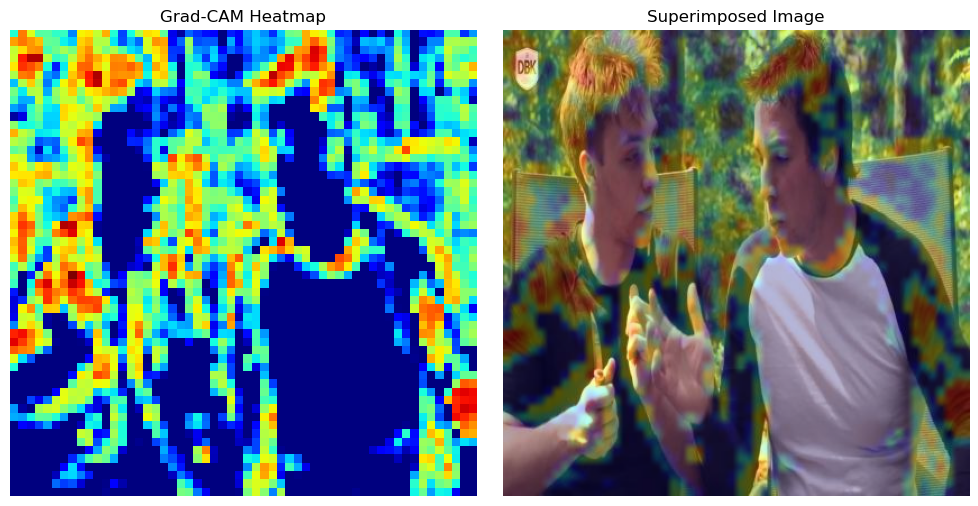

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
from PIL import Image as PilImage
from IPython.display import display, Image as IPImage
import os, random

# Assuming 'model' is your CCT model and it has been built and loaded correctly.

# Modify image preprocessing for CCT (assuming the model expects input of shape (224, 224, 3))
def get_img_array(img_path, size=(224, 224)):
    img = keras.utils.load_img(img_path, target_size=size)
    img_array = keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reshape(heatmap, (56, 56))
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Folder and image selection
folder_path = r"E:\Projects\Content-moderation\out\val\NSFW"
img_path = os.path.join(folder_path, random.choice([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]))
img_array = get_img_array(img_path)

# Build or load your CCT model
model = cct  # Replace with your CCT model
last_conv_layer_name = "dense_8"  # Replace with your actual last conv layer name

# Make predictions
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Superimpose the heatmap on the original image
def save_and_display_gradcam_side_by_side(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to the range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Resize the heatmap to match the image size
    jet_heatmap = PilImage.fromarray(np.uint8(jet_heatmap * 255))
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Plot the heatmap and superimposed image side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(heatmap, cmap="jet")
    axes[0].set_title("Grad-CAM Heatmap")
    axes[0].axis("off")

    axes[1].imshow(superimposed_img)
    axes[1].set_title("Superimposed Image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
save_and_display_gradcam_side_by_side(img_path, heatmap)


# SpectralVision

In [156]:
import tensorflow as tf
class GhostModule(tf.keras.layers.Layer):
    def __init__(self, inp, oup, kernel_size=1, ratio=2, dw_size=3, stride=1, relu=True):
        super(GhostModule, self).__init__()
        self.oup = oup
        init_channels = int(oup // ratio)  # Ensure it's an integer
        new_channels = int(init_channels * (ratio - 1))

        self.primary_conv = tf.keras.Sequential([
            layers.Conv2D(init_channels, kernel_size, stride, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU() if relu else layers.Activation('linear'),
        ])

        self.cheap_operation = tf.keras.Sequential([
            layers.DepthwiseConv2D(dw_size, 1, padding='same', use_bias=False),
            layers.BatchNormalization(),
            layers.ReLU() if relu else layers.Activation('linear'),
        ])

    def call(self, x):
        x1 = self.primary_conv(x)
        x2 = self.cheap_operation(x1)
        out = tf.concat([x1, x2], axis=-1)
        return out[:, :, :, :self.oup]

class TripletAttention(tf.keras.layers.Layer):
    def __init__(self, no_spatial=False, **kwargs):
        super(TripletAttention, self).__init__(**kwargs)
        self.no_spatial = no_spatial

    def channel_attention(self, x):
        x_perm = tf.transpose(x, perm=[0, 2, 1, 3]) 
        x_attn = tf.reduce_mean(x_perm, axis=1, keepdims=True)
        return tf.transpose(x_attn, perm=[0, 2, 1, 3])  

    def height_attention(self, x):
        x_perm = tf.transpose(x, perm=[0, 3, 2, 1])  # Swap height and channels
        x_attn = tf.reduce_mean(x_perm, axis=1, keepdims=True)
        return tf.transpose(x_attn, perm=[0, 3, 2, 1])  

    def spatial_attention(self, x):
        return tf.reduce_mean(x, axis=-1, keepdims=True)

    def call(self, x):
        x_cw = self.channel_attention(x)
        x_hw = self.height_attention(x)
        x_sp = self.spatial_attention(x) if not self.no_spatial else 0

        # Combine attentions
        if not self.no_spatial:
            x = (x_cw + x_hw + x_sp) / 3.0
        else:
            x = (x_cw + x_hw) / 2.0
        return x



class NeighborhoodAttention(tf.keras.layers.Layer):
    def __init__(self, kernel_size=7, num_heads=4, key_dim=None, attn_dropout=0.0, name=None):
        super().__init__(name=name)
        self.kernel_size = kernel_size
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attn_dropout = attn_dropout

    def build(self, input_shape):
        channels = input_shape[-1]
        self.key_dim = self.key_dim or channels // self.num_heads
        self.qkv_layer = layers.Dense(self.num_heads * self.key_dim * 3)
        self.attn_dropout_layer = layers.Dropout(self.attn_dropout)
        self.output_layer = layers.Dense(channels)

    def call(self, inputs):
        batch_size, height, width, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]
        qkv = self.qkv_layer(inputs)  # [batch, height, width, num_heads * key_dim * 3]
        qkv = tf.reshape(qkv, [-1, height * width, self.num_heads, 3 * self.key_dim])
        query, key, value = tf.split(qkv, 3, axis=-1)  # Split into Q, K, V
        query = tf.transpose(query, [0, 2, 1, 3])  # [batch, num_heads, height * width, key_dim]
        key = tf.transpose(key, [0, 2, 3, 1])      # [batch, num_heads, key_dim, height * width]
        attention_scores = tf.matmul(query, key) / tf.math.sqrt(float(self.key_dim))  # [batch, num_heads, height * width, height * width]
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        attention_scores = self.attn_dropout_layer(attention_scores)
        value = tf.transpose(value, [0, 2, 1, 3])  # [batch, num_heads, height * width, key_dim]
        attention_output = tf.matmul(attention_scores, value)  # [batch, num_heads, height * width, key_dim]
        attention_output = tf.transpose(attention_output, [0, 2, 1, 3])  # [batch, height * width, num_heads, key_dim]
        attention_output = tf.reshape(attention_output, [batch_size, height, width, self.num_heads * self.key_dim])  # [batch, height, width, num_heads * key_dim]
        return self.output_layer(attention_output)
        
        


In [157]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def create_optimized_custom_cnn():
    input_layer = layers.Input(shape=(224, 224, 3))  # Correct usage of Input
    ghost1 = GhostModule(inp=3, oup=32, kernel_size=3)(input_layer)
    downsample = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(ghost1)
    downsample_2 = layers.MaxPooling2D(pool_size=(2, 2))(downsample)
    nat = NeighborhoodAttention(kernel_size=3, num_heads=1, name="nat1")(downsample_2)  # Ensure NeighborhoodAttention is defined
    conv_layer_1 = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(nat)
    conv_layer_1 = layers.BatchNormalization()(conv_layer_1)
    global_avg_pool = layers.GlobalAveragePooling2D()(conv_layer_1)
    fc_layer_1 = layers.Dense(128, activation="relu")(global_avg_pool)
    fc_layer_1 = layers.BatchNormalization()(fc_layer_1)

    fc_layer_2 = layers.Dense(64, activation="relu")(fc_layer_1)
    fc_layer_2 = layers.BatchNormalization()(fc_layer_2)

    output_layer = layers.Dense(2, activation="softmax")(fc_layer_2)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Instantiate and summarize the model
optimized_custom_cnn_model = create_optimized_custom_cnn()
optimized_custom_cnn_model.summary()


Model: "model_147"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 ghost_module (GhostModule)  (None, 224, 224, 32)      704       
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 nat1 (NeighborhoodAttention  (None, 56, 56, 32)       4224      
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        18

In [158]:
# Specify the path to your weights file
weights_path = r"E:\Projects\Content-moderation\weights\custom_cnn_model.hdf5"

# Load the weights into the model
optimized_custom_cnn_model.load_weights(weights_path)

# Verify the model has loaded the weights
print("Weights loaded successfully.")


Weights loaded successfully.


# GradCAM

Selected File: E:\Projects\Content-moderation\out\val\NSFW\33f12d2d7bb0cdfdd095c91a097a15ccf08acd91_full_jpg.rf.084d61026b6675cb612698c7a33f75ad.jpg


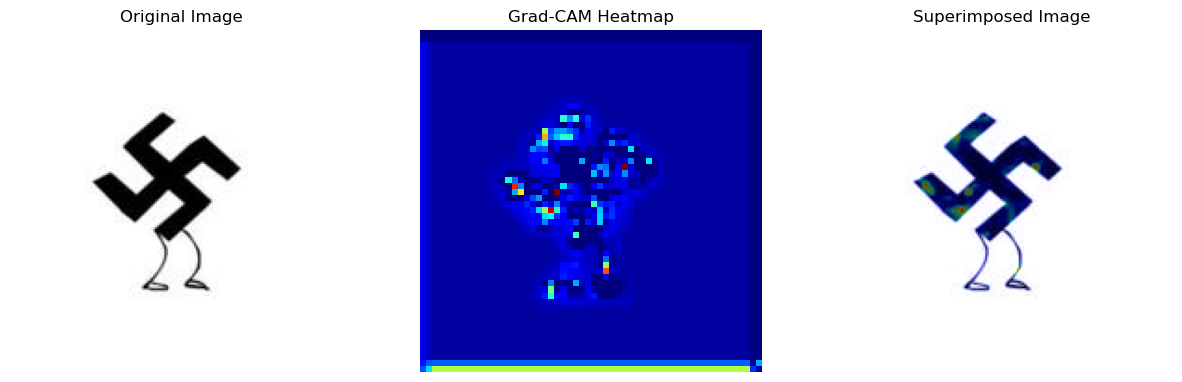

In [498]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def make_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given model and input image.
    """
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def apply_heatmap(heatmap, original_img, alpha=0.4):
    """
    Applies a jet colormap to the heatmap and superimposes it on the original image.
    """
    # Scale the heatmap to range [0, 255]
    heatmap = np.uint8(255 * heatmap)

    # Expand dimensions to make it 3D for resizing
    heatmap = np.expand_dims(heatmap, axis=-1)

    # Resize heatmap to match the original image size
    heatmap_resized = tf.image.resize(heatmap, (original_img.shape[0], original_img.shape[1]))
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()  # Remove unnecessary dimension

    # Apply colormap (jet) to the heatmap
    colormap = plt.cm.jet(heatmap_resized / 255.0)  # Normalize for colormap
    colormap = (colormap[:, :, :3] * 255).astype(np.uint8)  # Drop alpha channel

    # Superimpose heatmap on the original image
    superimposed_img = colormap * alpha + original_img
    superimposed_img = np.clip(superimposed_img / 255.0, 0, 1)  # Normalize to [0, 1]
    return superimposed_img

def preprocess_image(img_path, target_size):
    """
    Loads and preprocesses an image for the model.
    """
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array / 255.0

# Select a random file from a folder
folder_path = r"E:\Projects\Content-moderation\out\val\NSFW"
random_file = random.choice(os.listdir(folder_path))
img_path = os.path.join(folder_path, random_file)

print(f"Selected File: {img_path}")

# Preprocess the selected image
img_array = preprocess_image(img_path, target_size=(224, 224))

# Perform Grad-CAM
last_conv_layer_name = "batch_normalization_2"  # Replace with the name of the last convolutional layer in your model
heatmap = make_gradcam_heatmap(optimized_custom_cnn_model, img_array, last_conv_layer_name)

# Display the heatmap
original_img = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(img_path))
superimposed_img = apply_heatmap(heatmap, original_img)

# Plot the original image, heatmap, and superimposed image
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_img.astype("uint8"))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(heatmap, cmap="jet")  # Use jet colormap for heatmap visualization
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Superimposed Image")
plt.imshow(superimposed_img)
plt.axis("off")

plt.show()


#  ConitNet

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Subset


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, pad=0):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=pad)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes, eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )
        self.pool_types = pool_types

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type == 'avg':
                avg_pool = F.avg_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type == 'max':
                max_pool = F.max_pool2d(x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp(max_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = torch.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat((torch.max(x, 1)[0].unsqueeze(1), torch.mean(x, 1).unsqueeze(1)), dim=1)

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size - 1) // 2, relu=False)

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = torch.sigmoid(x_out)  # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial = no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()

    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

class ContextBlock(nn.Module):
    def __init__(self, inplanes, ratio=1/16, pooling_type='att'):
        super(ContextBlock, self).__init__()
        assert pooling_type in ['avg', 'att']
        self.inplanes = inplanes
        self.ratio = ratio
        self.planes = int(inplanes * ratio)
        self.pooling_type = pooling_type

        if pooling_type == 'att':
            self.conv_mask = nn.Conv2d(inplanes, 1, kernel_size=1)
            self.softmax = nn.Softmax(dim=2)
        else:
            self.avg_pool = nn.AdaptiveAvgPool2d(1)

        self.channel_add_conv = nn.Sequential(
            nn.Conv2d(self.inplanes, self.planes, kernel_size=1),
            nn.LayerNorm([self.planes, 1, 1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(self.planes, self.inplanes, kernel_size=1)
        )
        self.reset_parameters()

    def reset_parameters(self):
        if self.pooling_type == 'att':
            nn.init.kaiming_normal_(self.conv_mask.weight, mode='fan_in')
            self.conv_mask.inited = True

        nn.init.constant_(self.channel_add_conv[-1].weight, 0)
        nn.init.constant_(self.channel_add_conv[-1].bias, 0)

    def spatial_pool(self, x):
        batch, channel, height, width = x.size()
        if self.pooling_type == 'att':
            input_x = x.view(batch, channel, height * width)
            input_x = input_x.unsqueeze(1)
            context_mask = self.conv_mask(x).view(batch, 1, height * width)
            context_mask = self.softmax(context_mask).unsqueeze(-1)
            context = torch.matmul(input_x, context_mask).view(batch, channel, 1, 1)
        else:
            context = self.avg_pool(x)
        return context

    def forward(self, x):
        context = self.spatial_pool(x)
        channel_add_term = self.channel_add_conv(context)
        out = x + channel_add_term
        return out

class CustomModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(CustomModel, self).__init__()
        self.conv1 = ConvBlock(in_channels, 8, 7, pad=3)
        self.conv2 = ConvBlock(8, 32, 7, pad=3)
        self.max_pool1 = nn.MaxPool2d(2)
        self.context1 = ContextBlock(32, ratio=1/8)
        
        self.conv3 = ConvBlock(32, 64, kernel_size=3, pad=1)
        self.context2 = ContextBlock(64, ratio=1/8)
        
        self.conv4 = ConvBlock(64, 128, kernel_size=3, pad=1)
        self.context3 = ContextBlock(128, ratio=1/8)
        
        self.conv5 = ConvBlock(128, 256, kernel_size=3, pad=1)
        self.context4 = ContextBlock(256, ratio=1/8)
        
        # self.conv6 = ConvBlock(256, 512, kernel_size=3, pad=1)
        # self.context5 = ContextBlock(512, ratio=1/8)
        
        self.conv7 = ConvBlock(256, 512, kernel_size=3, pad=1)
        self.context6 = ContextBlock(512, ratio=1/8)
        
        self.conv8 = ConvBlock(512, 1024, kernel_size=3, pad=1)
        self.context7 = ContextBlock(1024, ratio=1/8)
        
        self.max_pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)
        self.bn2d = nn.BatchNorm2d(1024)
        self.cbam_block1 = CBAM(1024)  # Moved CBAM here
        self.fc1 = nn.Linear(1024 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.context1(x)
        x = self.max_pool1(x)

        x = self.conv3(x)
        x = self.context2(x)
        # x = self.max_pool2(x)

        x = self.conv4(x)
        x = self.context3(x)
        x = self.max_pool2(x)

        x = self.conv5(x)
        x = self.context4(x)
        x = self.max_pool2(x)

        # x = self.conv6(x)
        # x = self.context5(x)
        # x = self.max_pool2(x)
        
        x = self.conv7(x)
        x = self.context6(x)
        x = self.max_pool2(x)
        
        x = self.conv8(x)
        x = self.context7(x)
        x = self.max_pool2(x)
        x = self.cbam_block1(x)
        # print(x.shape)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# model = CustomModel()
# random_image = torch.randn(1, 3, 224, 224)
# # print(model)
# output = model(random_image)
# print(output.shape)


In [4]:
model = CustomModel(in_channels=3, num_classes=2)
model.load_state_dict(torch.load('custom_modelbest1.pth',map_location=torch.device('cpu')))
print(model)

C:\Users\Jeevan Prakash\AppData\Local\Temp\ipykernel_17572\228009825.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('custom_modelbest1.

CustomModel(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (conv2): ConvBlock(
    (conv): Conv2d(8, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (context1): ContextBlock(
    (conv_mask): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (softmax): Softmax(dim=2)
    (channel_add_conv): Sequential(
      (0): Conv2d(32, 4, kernel_size=(1, 1), stride=(1, 1))
      (1): LayerNorm((4, 1, 1), eps=1e-05, elementwise_affine=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv3): ConvBlock(
    (conv): Conv2d(32, 64, kernel_size=(3

# GradCAM

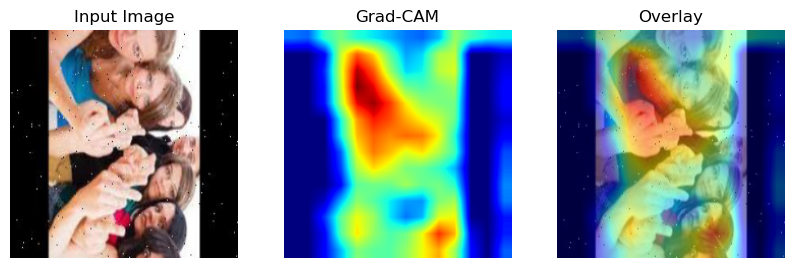

In [77]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Normalize
import os
import random

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for activations
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_image, class_idx):
        # Forward pass
        output = self.model(input_image)

        # Zero gradients and compute backward pass for target class
        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        # Compute Grad-CAM
        gradients = self.gradients.detach().cpu().numpy()[0]
        activations = self.activations.detach().cpu().numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        # Normalize the CAM
        cam = np.maximum(cam, 0)
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

def visualize_gradcam(model, gradcam, input_image, class_idx, mean, std):
    # Generate Grad-CAM
    cam = gradcam.generate_cam(input_image, class_idx)

    # Process the input image for visualization
    input_image_np = input_image.cpu().numpy()[0].transpose(1, 2, 0)
    input_image_np = input_image_np * std + mean
    input_image_np = np.clip(input_image_np, 0, 1)

    # Resize CAM to match input image size
    cam_resized = cv2.resize(cam, (input_image_np.shape[1], input_image_np.shape[0]))

    # Overlay the CAM on the input image
    heatmap = plt.cm.jet(cam_resized)[:, :, :3]
    overlay = 0.5 * input_image_np + 0.5 * heatmap

    # Plot the images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(input_image_np)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM")
    plt.imshow(cam_resized, cmap='jet')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis('off')
    plt.show()

# Example usage
if __name__ == "__main__":
    import cv2
    from torchvision.transforms import ToTensor
    model.eval()

    # Specify the target layer (last convolutional layer)
    target_layer = model.conv8

    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)

    # Prepare input image
    folder_path = r"E:\Projects\Content-moderation\out\val\NSFW"  # Replace with your folder path
    image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    random_image_path = os.path.join(folder_path, random.choice(image_files))

    image = cv2.imread(random_image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (224, 224))
    image_tensor = ToTensor()(image_resized).unsqueeze(0)

    # Normalize image
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = Normalize(mean=mean, std=std)
    input_image = normalize(image_tensor)

    # Predict and visualize Grad-CAM
    class_idx = torch.argmax(model(input_image)).item()
    visualize_gradcam(model, gradcam, input_image, class_idx, mean, std)
